<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/abc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
mix_index = [
    0.02433994708994693,
    0.1196104497354502,
    0.16866005291005123,
    0.24411481481481234,
    0.43469285714285866
    ]

real_tau_list = [0.4, 0.5, 0.6, 0.7, 0.8]

In [16]:
import numpy as np
from scipy.signal import convolve2d

class abm:
    def __init__(self,
                 # Length of square grid
                 length_grid=None,
                 # Fraction of spots with agents
                 density=None,
                 # Possible values of the feature
                 n_features=None,
                 # Tolerance threshold for diversity
                 τ=None,
                 # Seed for reproducibility
                 seed=123
                 ):

        # Set seed
        np.random.seed(seed)

        # Set dimensions and parameters
        self.length_grid = length_grid if length_grid is not None else 100
        self.density = density if density is not None else 0.9
        self.n_features = n_features if n_features is not None else 2
        self.τ = τ if τ is not None else 0.6

        # Calculate grid size and number of agents
        self.size_grid = self.length_grid * self.length_grid
        self.n_agents = int(self.size_grid * self.density)

        # Initialize agents and grid
        self.agents = np.arange(self.n_agents)
        self.grid = np.empty(self.size_grid, dtype=float)
        self.agent_feature = np.zeros(self.n_agents, dtype=int)
        self.agent_positions = np.zeros((self.n_agents, 2), dtype=int)
        self.list_feature_grid = []
        self.list_mix = []

    def initialize(self):
        # Build grid with agents and empty spots
        self.grid[:self.n_agents] = self.agents
        self.grid[self.n_agents:] = np.nan
        np.random.shuffle(self.grid)
        self.grid = self.grid.reshape(self.length_grid, self.length_grid)

        # Assign features to agents
        self.agent_feature = np.random.choice(self.n_features, size=self.n_agents)

        # Map agent IDs to their positions
        occupied_positions = np.argwhere(~np.isnan(self.grid))
        agent_ids_in_grid = self.grid[~np.isnan(self.grid)].astype(int)
        self.agent_positions[agent_ids_in_grid] = occupied_positions

    def make_feature_grid(self):
        # Initialize feature grid with zeros (empty spaces)
        feature_grid = np.zeros_like(self.grid)

        # Get positions of agents
        agent_mask = ~np.isnan(self.grid)
        agent_ids = self.grid[agent_mask].astype(int)
        features = self.agent_feature[agent_ids]

        # Map features 0 to -1, features 1 to +1
        feature_values = np.where(features == 0, -1, 1)
        feature_grid[agent_mask] = feature_values

        return feature_grid

    def compute_neighbors(self):
        # Create feature grid
        feature_grid = self.make_feature_grid()

        # Create mask for occupied cells
        occupied_mask = feature_grid != 0  # Cells that are occupied

        # Define convolution kernel to consider 8 neighbors
        kernel = np.ones((3, 3), dtype=int)
        kernel[1, 1] = 0  # Exclude the center cell

        # Compute total number of occupied neighbors
        n_occupied_neighbors = convolve2d(occupied_mask.astype(int), kernel, mode='same', boundary='wrap')

        # Compute sum of neighbor features
        sum_neighbor_features = convolve2d(feature_grid, kernel, mode='same', boundary='wrap')

        # Get own features
        cell_features = feature_grid * occupied_mask  # Zero for empty cells, +/-1 for occupied cells

        # Multiply own feature by sum of neighbor features
        product = cell_features * sum_neighbor_features

        # Number of same-feature neighbors
        n_same_feature_neighbors = (n_occupied_neighbors + product) / 2
        n_diff_neighbors = n_occupied_neighbors - n_same_feature_neighbors

        # Calculate ratio of different neighbors
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_difference = np.where(n_occupied_neighbors > 0, n_diff_neighbors / n_occupied_neighbors, 1)

        return occupied_mask, ratio_difference

    def agents_move(self):
        occupied_mask, ratio_difference = self.compute_neighbors()

        # Compute mix average
        mix_average = np.nanmean(ratio_difference[occupied_mask])

        # Identify unhappy agents
        unhappy_mask = (ratio_difference > self.τ) & occupied_mask

        # If no agents are unhappy, return mix_average
        if not np.any(unhappy_mask):
            return mix_average

        # Get positions of unhappy agents
        unhappy_positions = np.argwhere(unhappy_mask)

        # Find empty positions
        empty_positions = np.argwhere(~occupied_mask)
        np.random.shuffle(empty_positions)
        n_unhappy_agents = len(unhappy_positions)
        n_empty_positions = len(empty_positions)

        # Determine the number of moves possible
        num_moves = min(n_unhappy_agents, n_empty_positions)
        if num_moves == 0:
            # No empty positions to move to
            return mix_average

        # Select agents and positions for movement
        selected_unhappy_positions = unhappy_positions[:num_moves]
        selected_empty_positions = empty_positions[:num_moves]

        # Move agents
        unhappy_agent_ids = self.grid[selected_unhappy_positions[:, 0], selected_unhappy_positions[:, 1]].astype(int)

        # Update grid
        self.grid[selected_empty_positions[:, 0], selected_empty_positions[:, 1]] = unhappy_agent_ids
        self.grid[selected_unhappy_positions[:, 0], selected_unhappy_positions[:, 1]] = np.nan

        # Update agent_positions
        self.agent_positions[unhappy_agent_ids] = selected_empty_positions

        return mix_average

    def all_agents_happy(self):
        occupied_mask, ratio_difference = self.compute_neighbors()

        # Identify unhappy agents
        unhappy_mask = (ratio_difference > self.τ) & occupied_mask

        # Find empty positions
        empty_positions = np.argwhere(~occupied_mask)
        if len(empty_positions) == 0:
            # No empty positions, agents cannot move
            return True

        # Check if any agent is unhappy
        return not np.any(unhappy_mask)

    def run(self):
        # Compute initial mix
        occupied_mask, ratio_difference = self.compute_neighbors()
        initial_mix = np.nanmean(ratio_difference[occupied_mask])

        # Add initial state to lists
        self.list_mix.append(initial_mix)
        self.list_feature_grid.append(self.make_feature_grid())

        counter_safety = 0
        # While not all agents are happy, move them
        while not self.all_agents_happy():
            # Move agents and calculate mix
            mt = self.agents_move()
            # Append mix and feature matrix to lists
            self.list_mix.append(mt)
            self.list_feature_grid.append(self.make_feature_grid())

            # Safety check to prevent infinite loops
            counter_safety += 1
            if counter_safety > 1000:
                print("Exceeded maximum iterations.")
                break

    def run_fast(self):
        counter_safety = 0
        # While not all agents are happy, move them
        while not self.all_agents_happy():
            # Move agents
            mt = self.agents_move()
            counter_safety += 1
            if counter_safety > 500:
                # print("Exceeded maximum iterations.")
                mt = np.nan
                break
        # Only save last step
        self.list_mix.append(mt)
        self.list_feature_grid.append(self.make_feature_grid())

def fit_model(mix_list, tau_list, tolerance=0.01, trials=100):
    assert len(mix_list) == len(tau_list)
    # Generate potential τ values from a uniform prior
    τ_potential = np.random.uniform(0.3, 0.9, size=trials)
    # Initialize list to store accepted τ values for each target τ
    τ_accepted = [[] for _ in range(len(tau_list))]

    # Iterate over potential τ samples
    for i, τ_hat in enumerate(τ_potential):
        # Run the model with the proposed τ_hat
        model = abm(τ=τ_hat)
        model.initialize()
        model.run_fast()
        mix_hat = model.list_mix[-1]

        # Check whether the resulting mix_hat is within tolerance for each target τ
        for j, (τ_true, mix_true) in enumerate(zip(tau_list, mix_list)):
            if np.abs(mix_hat - mix_true) < tolerance:
                τ_accepted[j].append(τ_hat)
                # print(f"Accepted τ_hat: {τ_hat} for τ_true: {τ_true} with mix_hat: {mix_hat}")

        if i % 10 == 0:
            print(f"Completed iteration {i}/{trials}")

    return τ_accepted

In [17]:
# Define mix indices and corresponding real τ values
mix_index = [
    0.02433994708994693,
    0.1196104497354502,
    0.16866005291005123,
    0.24411481481481234,
    0.43469285714285866
    ]

real_tau_list = [0.4, 0.5, 0.6, 0.7, 0.8]

# Run the fit_model function
%time τ_accepted = fit_model(mix_index, real_tau_list, tolerance=0.01, trials=5000)

Completed iteration 0/5000
Completed iteration 10/5000
Completed iteration 20/5000
Completed iteration 30/5000
Completed iteration 40/5000
Completed iteration 50/5000
Completed iteration 60/5000
Completed iteration 70/5000
Completed iteration 80/5000
Completed iteration 90/5000
Completed iteration 100/5000
Completed iteration 110/5000
Completed iteration 120/5000
Completed iteration 130/5000
Completed iteration 140/5000
Completed iteration 150/5000
Completed iteration 160/5000
Completed iteration 170/5000
Completed iteration 180/5000
Completed iteration 190/5000
Completed iteration 200/5000
Completed iteration 210/5000
Completed iteration 220/5000
Completed iteration 230/5000
Completed iteration 240/5000
Completed iteration 250/5000
Completed iteration 260/5000
Completed iteration 270/5000
Completed iteration 280/5000
Completed iteration 290/5000
Completed iteration 300/5000
Completed iteration 310/5000
Completed iteration 320/5000
Completed iteration 330/5000
Completed iteration 340/5

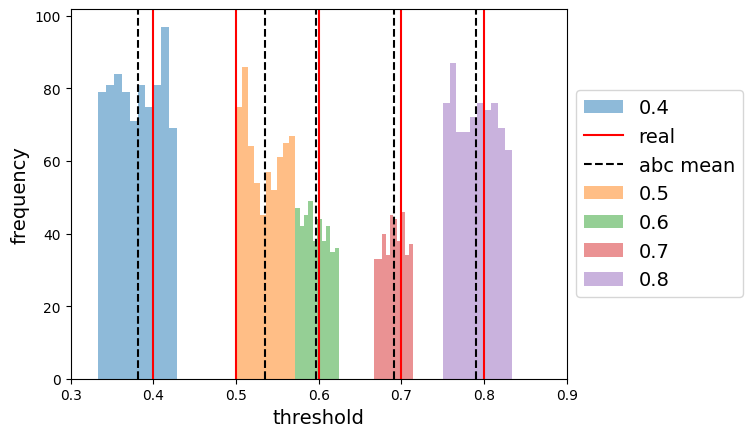

In [18]:
fig = plt.figure()
ax = plt.subplot(111)

for i, t_acc in enumerate(τ_accepted):
    ax.hist(τ_accepted[i], alpha=0.5, label=str(real_tau_list[i]))
    if i == 0:
        ax.axvline(x=real_tau_list[i], color="red", label="real")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k", label="abc mean")
    else:
        ax.axvline(x=real_tau_list[i], color="red")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim([0.3, 0.9])
plt.xlabel("threshold", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.show()